In [1]:
import sys
from pathlib import Path
from collections import Counter
import pandas as pd
import numpy as np

from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.seasonal import seasonal_decompose

import matplotlib.pyplot as plt
import seaborn as sns
from ydata_profiling import ProfileReport

# Garante que a raiz do projeto esteja no PYTHONPATH
PROJECT_ROOT = Path().resolve().parents[0]
sys.path.append(str(PROJECT_ROOT))

from src.paths import *
from src.config import *
from src.io import *

create_project_structure()
set_global_seed()

In [2]:
"""
Carregamento do dataset condicionado em formato Parquet.
"""

processed_path = PROCESSED_DATA_DIR / "mining_process_conditioned.parquet"
df = load_data(processed_path)

df.shape

(736282, 26)

# Objetivo da Análise Exploratória

A análise exploratória tem como objetivo:

- compreender a distribuição das variáveis;
- identificar relações estatísticas relevantes;
- avaliar padrões temporais e estruturais;
- levantar indícios de regimes operacionais;
- fornecer subsídios para engenharia de atributos e modelagem.

Esta etapa não busca otimizar modelos,
mas **entender profundamente o comportamento dos dados**.

# Ydata

In [ ]:
"""# Geração do profiling
profile = ProfileReport(
    df,
    title="Mining Process — Data Profiling",
    explorative=True,
    minimal=False
)

# Salvamento do relatório
report_path = REPORTS_DIR / "mining_process_ydata_profiling.html"
profile.to_file(report_path)

report_path""";

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

WindowsPath('C:/jupyter notebooks/IHM/reports/mining_process_ydata_profiling.html')

# EDA

## Estatísticas Descritivas — Análise Crítica

As estatísticas descritivas permitem observar:

- escalas muito distintas entre variáveis;
- variáveis com baixa variabilidade relativa;
- possíveis limites operacionais implícitos;
- dispersões compatíveis com medições industriais contínuas.

Diferenças de escala indicam que
normalização ou padronização poderá ser necessária em etapas futuras,
dependendo dos modelos utilizados.

In [3]:
df.describe().T

,count,mean,min,25%,50%,75%,max,std
date,736282,2017-06-16 02:30:44.009767936,2017-03-10 01:00:00,2017-05-04 21:00:00,2017-06-16 12:00:00,2017-07-29 09:00:00,2017-09-09 23:00:00,NaN
% Iron Feed,736282.0,56.298307,42.74,52.67,56.08,59.72,65.78,5.160365
% Silica Feed,736282.0,14.648984,1.31,8.94,13.85,19.6,33.4,6.810741
Starch Flow,736282.0,2869.636615,0.002026,2075.07,3020.23,3728.93,6300.23,1216.017896
Amina Flow,736282.0,488.165523,241.669,431.835848,504.3525,553.33575,739.538,91.254428
Ore Pulp Flow,736282.0,397.570736,376.249,394.248,399.238,402.967,418.641,9.705444
Ore Pulp pH,736282.0,9.767315,8.75334,9.52705,9.79746,10.0378,10.8081,0.387176
Ore Pulp Density,736282.0,1.680424,1.51982,1.64739,1.69758,1.72838,1.85325,0.069206
Flotation Column 01 Air Flow,736282.0,280.119813,175.51,250.278,299.341,300.147,373.871,29.633831
Flotation Column 02 Air Flow,736282.0,277.121249,175.156,250.448,296.202,300.686,375.992,30.157126


## Distribuição das Variáveis Alvo

As distribuições das variáveis alvo fornecem informações importantes sobre:

- amplitude de variação da qualidade do concentrado;
- assimetrias;
- possíveis limites físicos ou operacionais.

Distribuições concentradas podem indicar
operações estáveis, enquanto caudas longas
podem estar associadas a eventos específicos ou mudanças de regime.

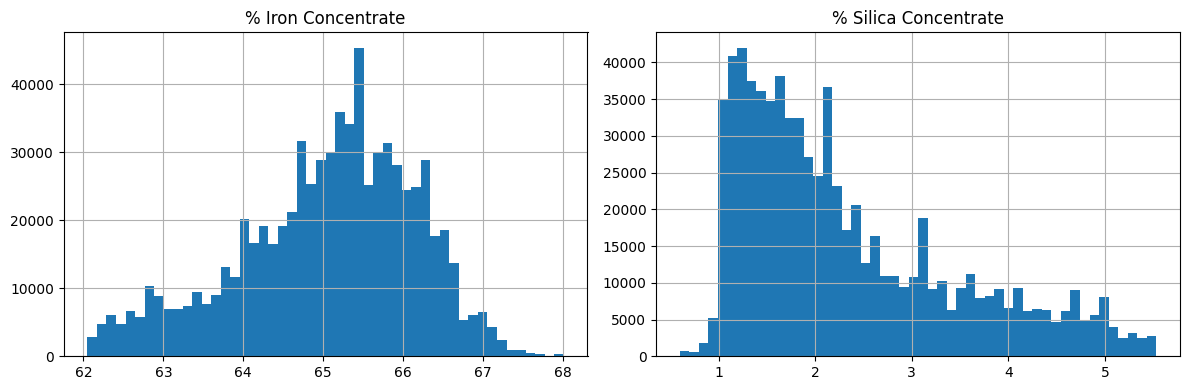

In [4]:
targets = ["% Iron Concentrate", "% Silica Concentrate"]

df[targets].hist(bins=50, figsize=(12, 4))
plt.tight_layout()

A variável `% Iron Concentrate` apresenta uma distribuição\
aproximadamente unimodal, com leve assimetria,\
concentrada em torno de valores operacionais típicos.\
\
Essa forma é compatível com:
- processos controlados;
- limites técnicos bem definidos;
- baixa variabilidade relativa (desvio padrão reduzido).

A variável `% Silica Concentrate` apresenta distribuição\
assimétrica à direita, com cauda longa.\
\
Esse comportamento sugere:
- maior sensibilidade a eventos pontuais;
- ocorrência ocasional de degradação da qualidade;
- assimetria típica de variáveis associadas a impurezas.

> O trade-off ferro–sílica não é apenas correlacional, mas distribucional.

Variáveis como:
- Ore Pulp Flow
- Ore Pulp pH
- Ore Pulp Density

apresentam distribuições aproximadamente normais, com baixa variabilidade relativa.\
\
Essas características indicam:
- operação estável;
- controle automático eficiente;
- baixo ruído operacional.

As vazões de ar das colunas de flotação, especialmente das colunas 04 e 05,\
apresentam distribuições altamente concentradas em torno de valores específicos.\
\
Esse padrão sugere:
- controle por setpoints;
- operação em regimes discretos;
- forte redundância informacional entre sensores similares.

Variáveis como:
- Starch Flow
- Amina Flow

apresentam ampla faixa de valores e caudas longas, indicando maior flexibilidade\
operacional e possível atuação como variáveis de controle fino do processo.



Distribuições altamente concentradas, associadas a valores dominantes\
e patamares operacionais, implicam naturalmente na repetição frequente\
de registros idênticos ou quase idênticos.\
\
Nesse contexto, registros duplicados:
- reforçam a presença de regimes estáveis;
- aumentam a massa estatística desses regimes;
- não distorcem análises descritivas globais.

Entretanto, eles podem enviesar modelos preditivos se não forem\
tratados explicitamente em etapas posteriores.

## Relação entre Teor de Ferro e Teor de Sílica

A correlação entre `% Iron Concentrate` e `% Silica Concentrate`
fornece evidências empíricas do trade-off clássico do processo.

Uma correlação negativa indica que melhorias em um indicador
tendem a ocorrer à custa do outro, refletindo decisões reais
do processo produtivo.

Esse comportamento deve ser considerado
na interpretação de modelos preditivos.

In [5]:
df[targets].corr()

,% Iron Concentrate,% Silica Concentrate
% Iron Concentrate,1.000000,-0.800598
% Silica Concentrate,-0.800598,1.000000


In [6]:
df[targets].corr(method='spearman')

,% Iron Concentrate,% Silica Concentrate
% Iron Concentrate,1.000000,-0.776776
% Silica Concentrate,-0.776776,1.000000


In [7]:
corr_with_target = (
    df.corr()[targets]
      .sort_values(by="% Iron Concentrate", ascending=False)
)

corr_with_target.head(10)

,% Iron Concentrate,% Silica Concentrate
% Iron Concentrate,1.000000,-0.800598
Ore Pulp pH,0.192443,-0.147211
Flotation Column 05 Level,0.159959,-0.168466
Flotation Column 07 Level,0.145849,-0.140819
Flotation Column 04 Level,0.136385,-0.148886
Flotation Column 03 Air Flow,0.099659,-0.218834
Flotation Column 01 Air Flow,0.098089,-0.219076
Flotation Column 05 Air Flow,0.087881,-0.008930
Ore Pulp Flow,0.082779,0.008497
Flotation Column 06 Level,0.081788,-0.102115


In [8]:
corr_with_target = (
    df.corr(method='spearman')[targets]
      .sort_values(by="% Iron Concentrate", ascending=False)
)

corr_with_target.head(10)

,% Iron Concentrate,% Silica Concentrate
% Iron Concentrate,1.000000,-0.776776
Ore Pulp pH,0.199408,-0.149564
Flotation Column 05 Level,0.183495,-0.191496
Flotation Column 04 Level,0.161234,-0.179945
Flotation Column 07 Level,0.157121,-0.160040
Flotation Column 06 Level,0.107199,-0.128985
Starch Flow,0.075807,-0.070334
Flotation Column 03 Air Flow,0.075287,-0.179657
Flotation Column 05 Air Flow,0.075031,-0.010246
Flotation Column 01 Air Flow,0.072990,-0.181497


## Correlações com Variáveis de Processo

As correlações observadas indicam que:

- algumas variáveis de processo apresentam relação estatística
  mais forte com a qualidade do concentrado;
- correlação não implica causalidade;
- relações fracas não invalidam a utilidade preditiva,
  especialmente em contextos multivariados.

Essas observações orientam,
mas não determinam,
as escolhas de features nas próximas etapas.

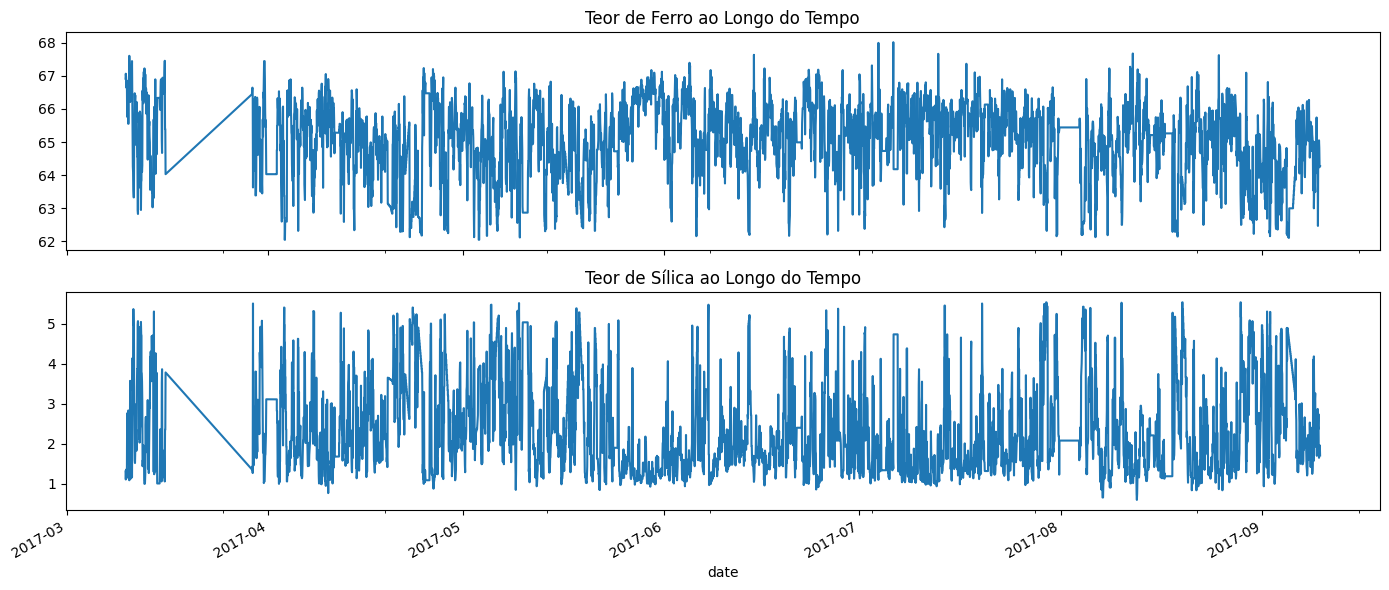

In [9]:
fig, ax = plt.subplots(2, 1, figsize=(14, 6), sharex=True)

df.plot(x="date", y="% Iron Concentrate", ax=ax[0], legend=False)
ax[0].set_title("Teor de Ferro ao Longo do Tempo")

df.plot(x="date", y="% Silica Concentrate", ax=ax[1], legend=False)
ax[1].set_title("Teor de Sílica ao Longo do Tempo")

plt.tight_layout()

## Correlações gerais

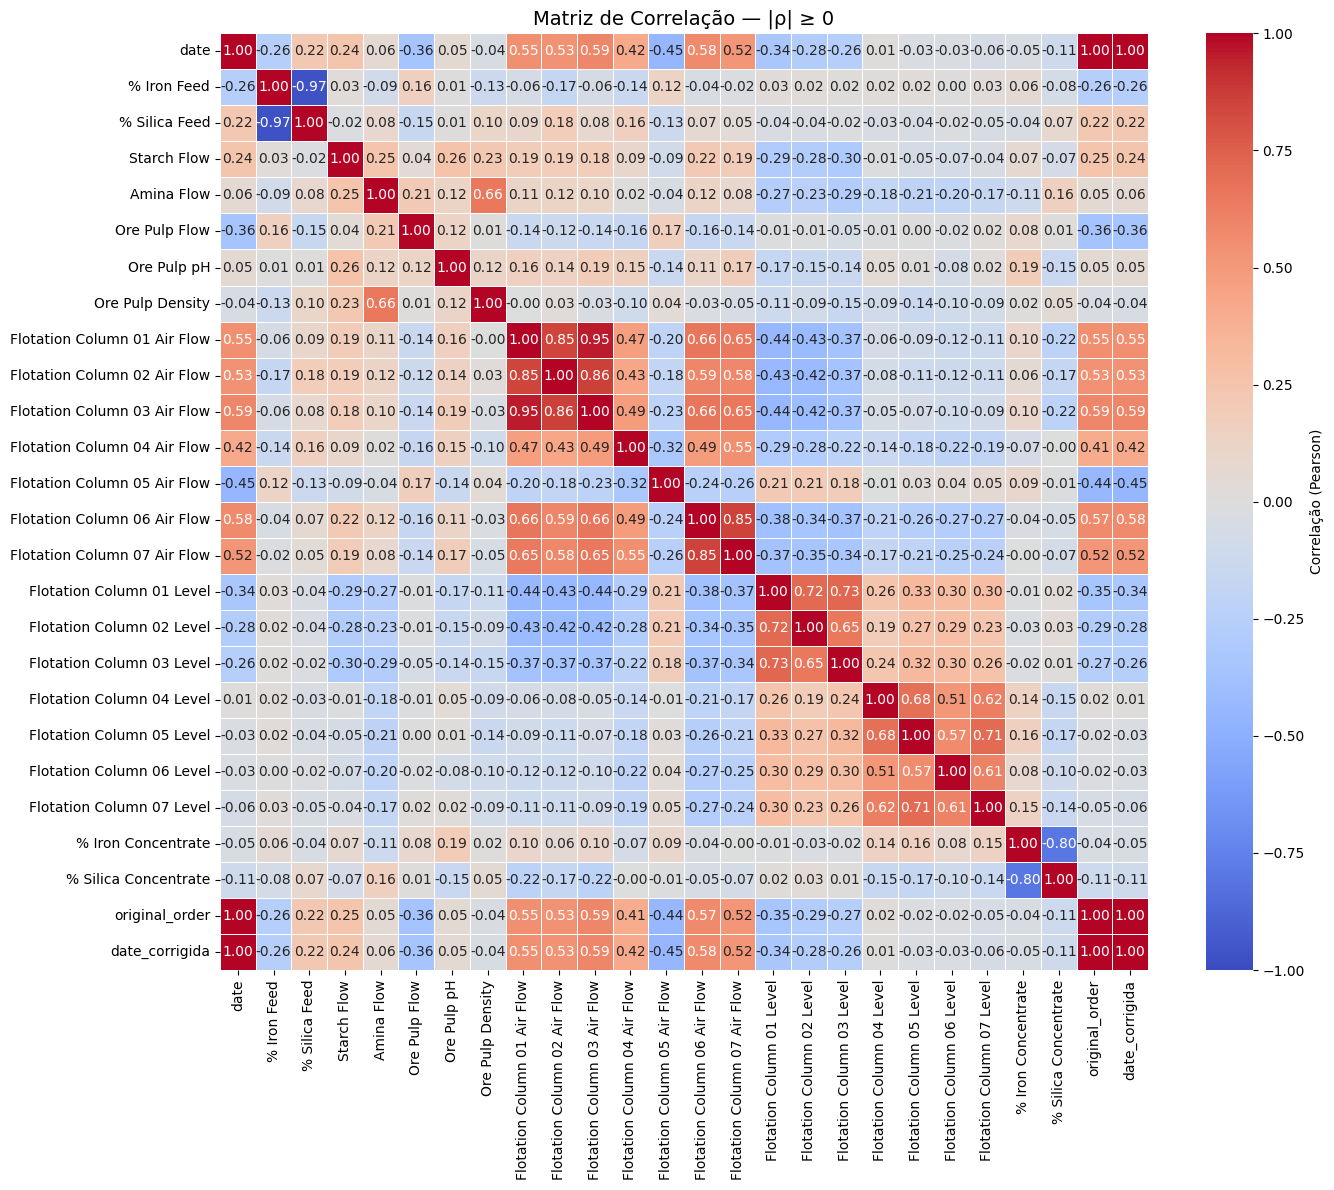

In [10]:
# Cálculo da matriz de correlação
corr = df.corr()

# Máscara para manter apenas correlações fortes (>= 0.90 em módulo)
mask = np.abs(corr) < 0

# Plot
plt.figure(figsize=(14, 12))
sns.heatmap(
    corr,
    mask=mask,
    cmap="coolwarm",
    vmin=-1,
    vmax=1,
    center=0,
    annot=True,
    fmt=".2f",
    linewidths=0.5,
    cbar_kws={"label": "Correlação (Pearson)"}
)

plt.title("Matriz de Correlação — |ρ| ≥ 0", fontsize=14)
plt.tight_layout()
plt.show()


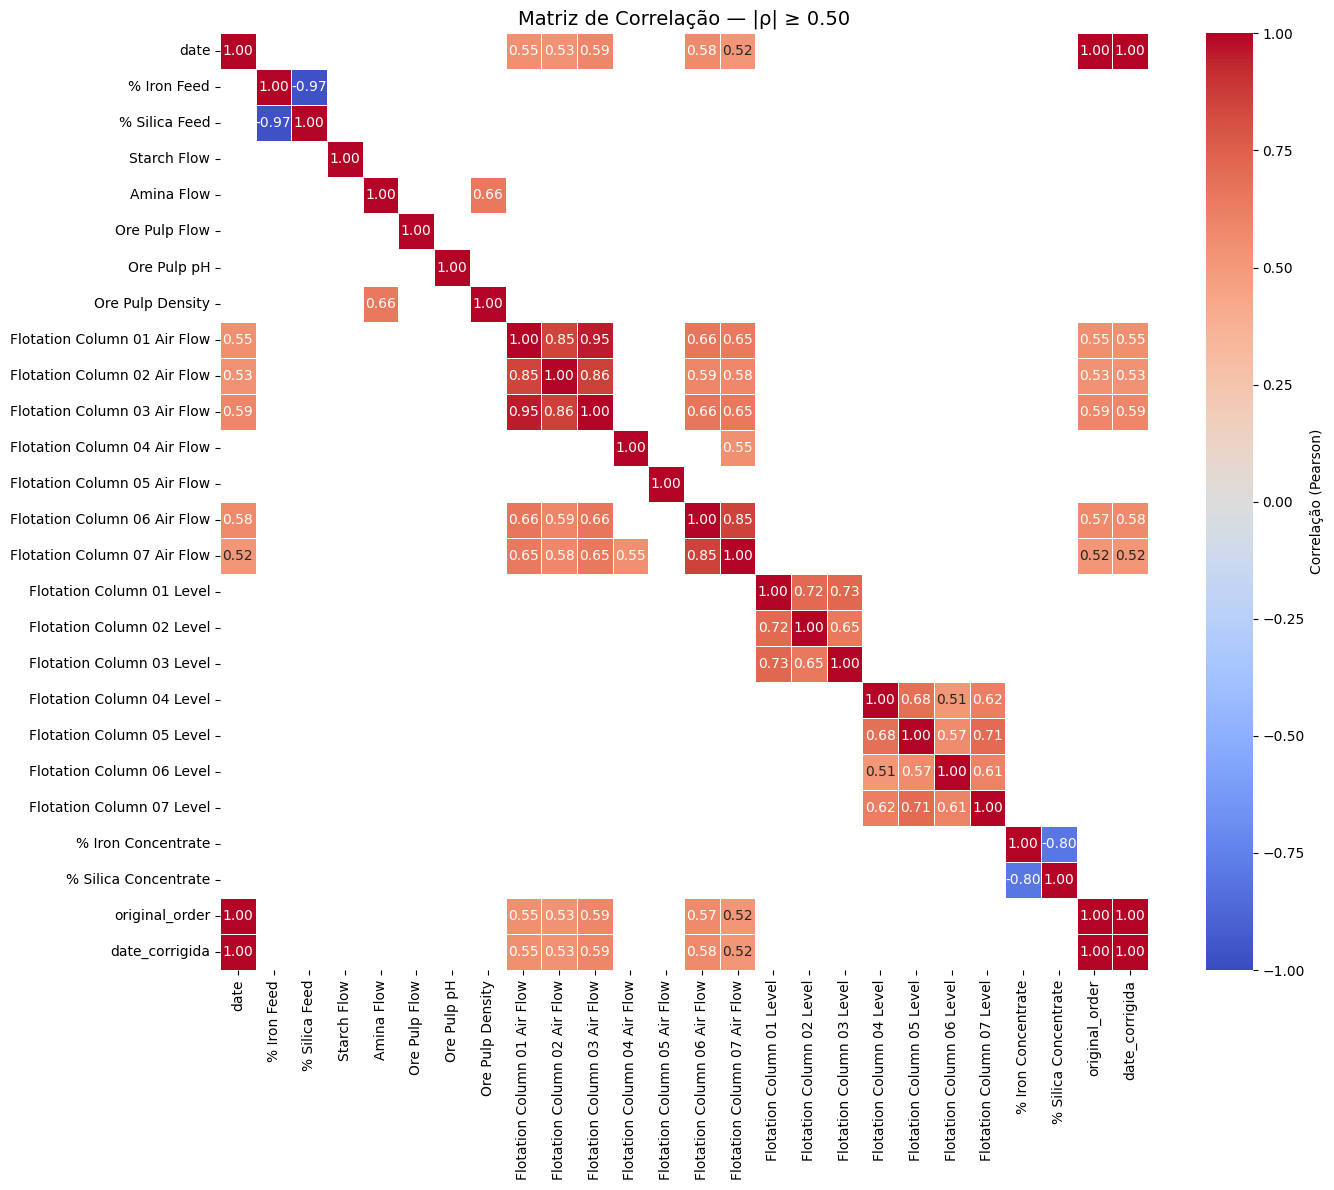

In [11]:
# Cálculo da matriz de correlação
corr = df.corr()

# Máscara para manter apenas correlações fortes (>= 0.90 em módulo)
mask = np.abs(corr) < 0.50

# Plot
plt.figure(figsize=(14, 12))
sns.heatmap(
    corr,
    mask=mask,
    cmap="coolwarm",
    vmin=-1,
    vmax=1,
    center=0,
    annot=True,
    fmt=".2f",
    linewidths=0.5,
    cbar_kws={"label": "Correlação (Pearson)"}
)

plt.title("Matriz de Correlação — |ρ| ≥ 0.50", fontsize=14)
plt.tight_layout()
plt.show()


# Análise Temporal Exploratória

A visualização temporal sugere:

- períodos de maior estabilidade operacional;
- possíveis mudanças de regime ao longo do tempo;
- eventos pontuais que se afastam do comportamento típico.

Esses padrões reforçam a importância de:
- validações temporais adequadas;
- uso de defasagens e janelas móveis;
- cautela ao assumir estacionariedade.

Esta etapa tem como objetivo analisar a dinâmica temporal do processo de flotação,
considerando os dados já condicionados e organizados segundo uma sequência temporal
reconstruída.

Busca-se compreender:
- estabilidade e variabilidade dos sinais ao longo do tempo;
- existência de padrões recorrentes;
- indícios de regimes operacionais;
- coerência temporal entre variáveis de processo e variáveis de qualidade.

Não se trata, nesta etapa, de modelagem preditiva ou inferência causal,
mas de caracterização do comportamento dinâmico do processo.


## Eixo Temporal Utilizado

Todas as análises temporais deste notebook utilizam a variável `date_corrigida`,
que representa uma reconstrução explícita da sequência de amostragem,
assumindo intervalo médio de 20 segundos entre observações consecutivas.

A variável `date` original não é utilizada para análises temporais,
por não representar adequadamente a ordem real das medições.


In [12]:
df = df.sort_values("date_corrigida").reset_index(drop=True)

## Das variáveis independentes

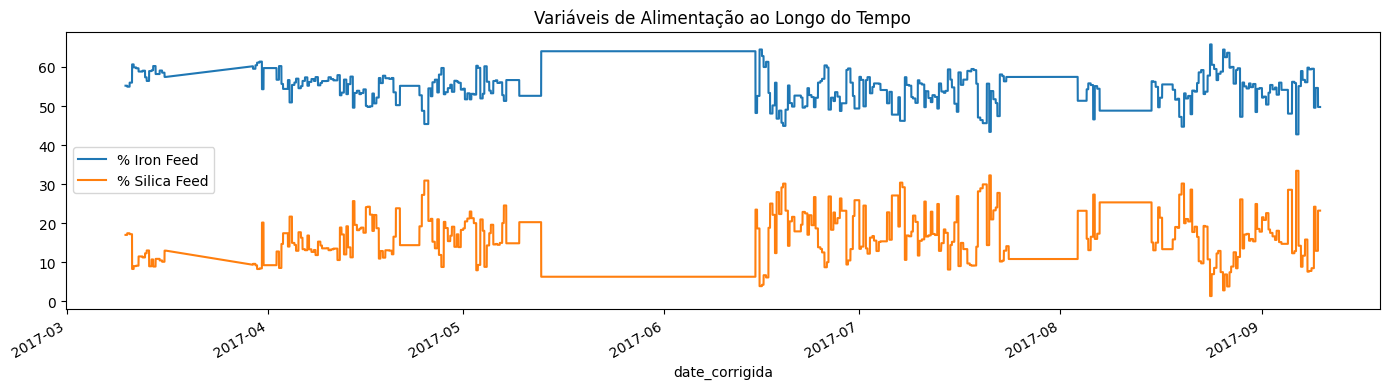

In [13]:
feed_vars = ["% Iron Feed", "% Silica Feed"]

df.plot(
    x="date_corrigida",
    y=feed_vars,
    figsize=(14, 4),
    title="Variáveis de Alimentação ao Longo do Tempo"
)
plt.tight_layout()
plt.show()

* Variações em degraus, não contínuas
* Longos períodos praticamente constantes
* Mudanças relativamente abruptas entre patamares
* Relação inversa clara entre ferro e sílica na alimentação

Interpretação:
* Essas variáveis não são controladas em tempo real, mas sim:
    * definidas por características do minério;
    * associadas a lotes, frentes de lavra ou blendagens;
    * alteradas por decisões operacionais de maior escala temporal.

As variáveis de alimentação funcionam como condições de contorno do processo,\
não como instrumentos de controle. Elas definem o “contexto metalúrgico” sob o\
qual o restante do sistema opera.

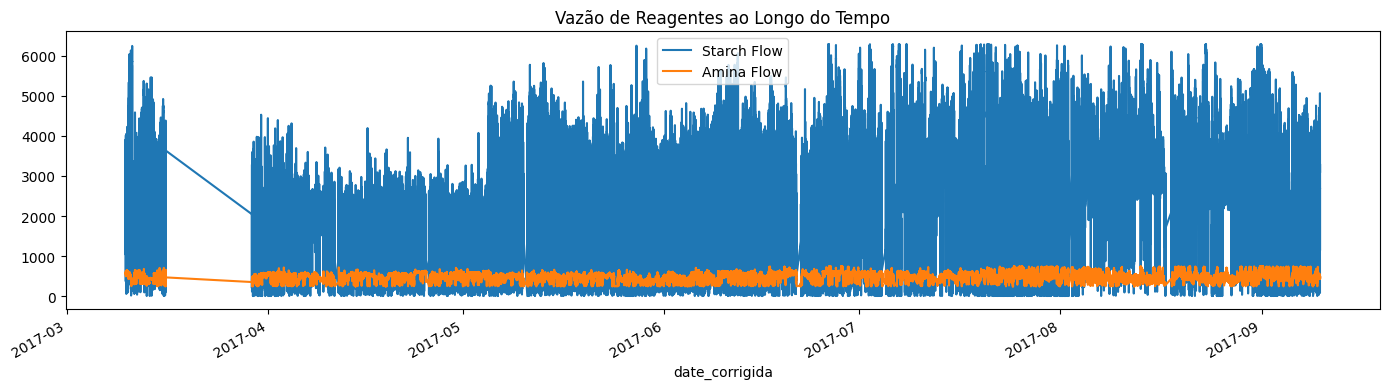

In [14]:
reagent_vars = ["Starch Flow", "Amina Flow"]

df.plot(
    x="date_corrigida",
    y=reagent_vars,
    figsize=(14, 4),
    title="Vazão de Reagentes ao Longo do Tempo"
)
plt.tight_layout()
plt.show()

* Alta variabilidade em toda a série
* Oscilações frequentes e de grande amplitude
* Mudança gradual do nível médio ao longo do tempo
* Comportamento muito mais dinâmico que a alimentação

Interpretação
* Os reagentes são variáveis de controle ativo, ajustadas:
    * para compensar variações na alimentação;
    * para manter a qualidade do concentrado;
    * para reagir a desvios operacionais de curto prazo.

* O aumento gradual do nível médio sugere:
    * mudança de estratégia operacional;
    * alteração nas características do minério;
    * ou ajuste progressivo de setpoints ao longo do período.

As vazões de reagentes representam o principal grau de liberdade operacional\
do processo e devem ter papel central em qualquer análise preditiva.

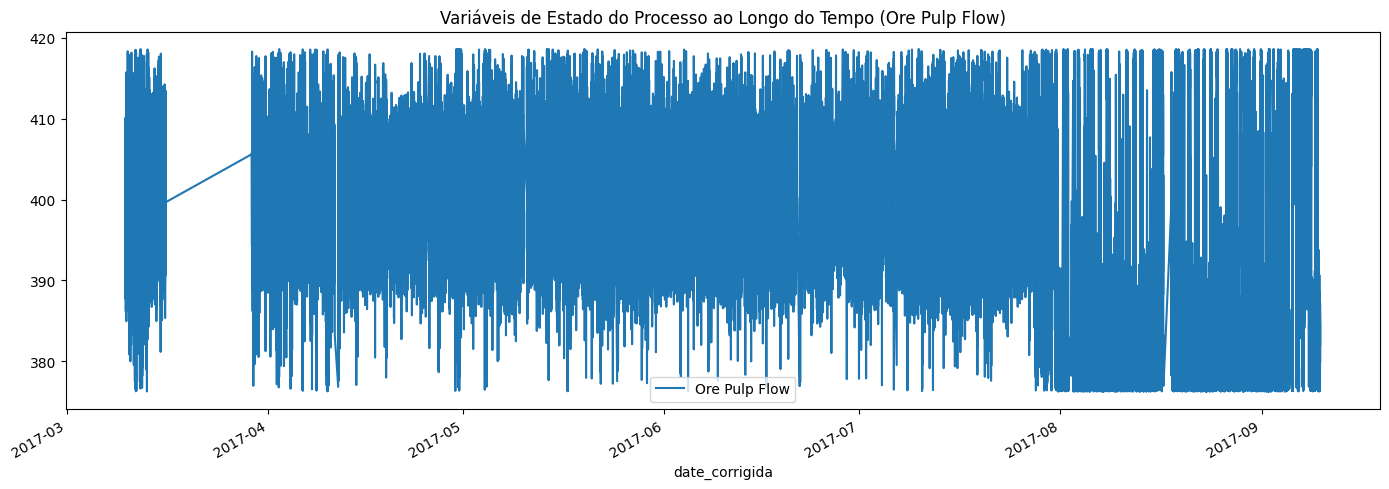

In [15]:
state_vars = ["Ore Pulp Flow"]

df.plot(
    x="date_corrigida",
    y=state_vars,
    figsize=(14, 5),
    title="Variáveis de Estado do Processo ao Longo do Tempo (Ore Pulp Flow)"
)
plt.tight_layout()
plt.show()

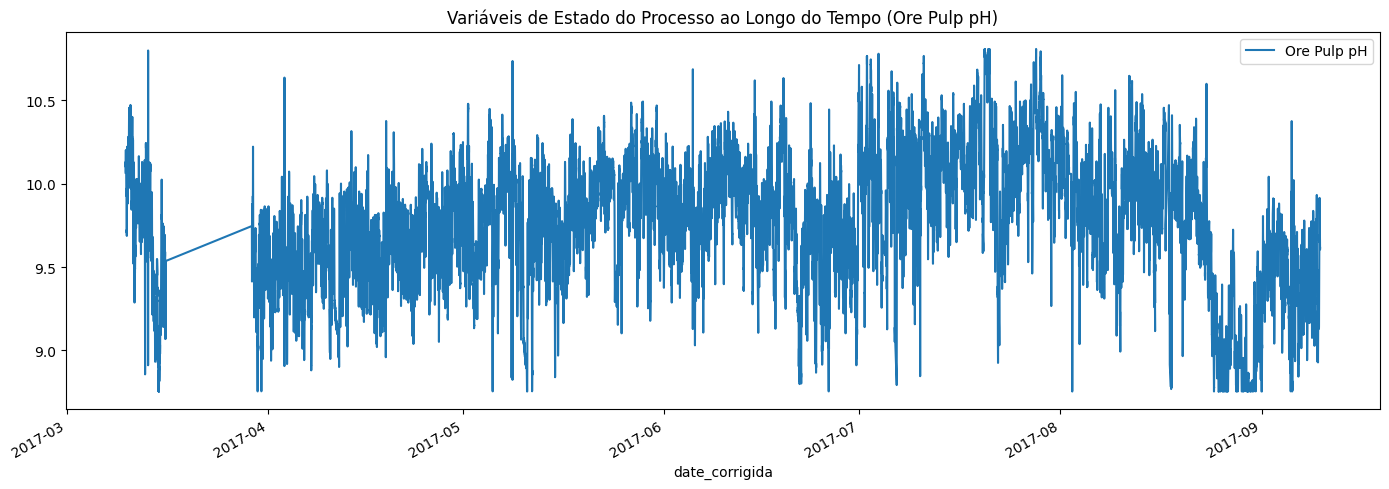

In [16]:
state_vars = ["Ore Pulp pH"]

df.plot(
    x="date_corrigida",
    y=state_vars,
    figsize=(14, 5),
    title="Variáveis de Estado do Processo ao Longo do Tempo (Ore Pulp pH)"
)
plt.tight_layout()
plt.show()

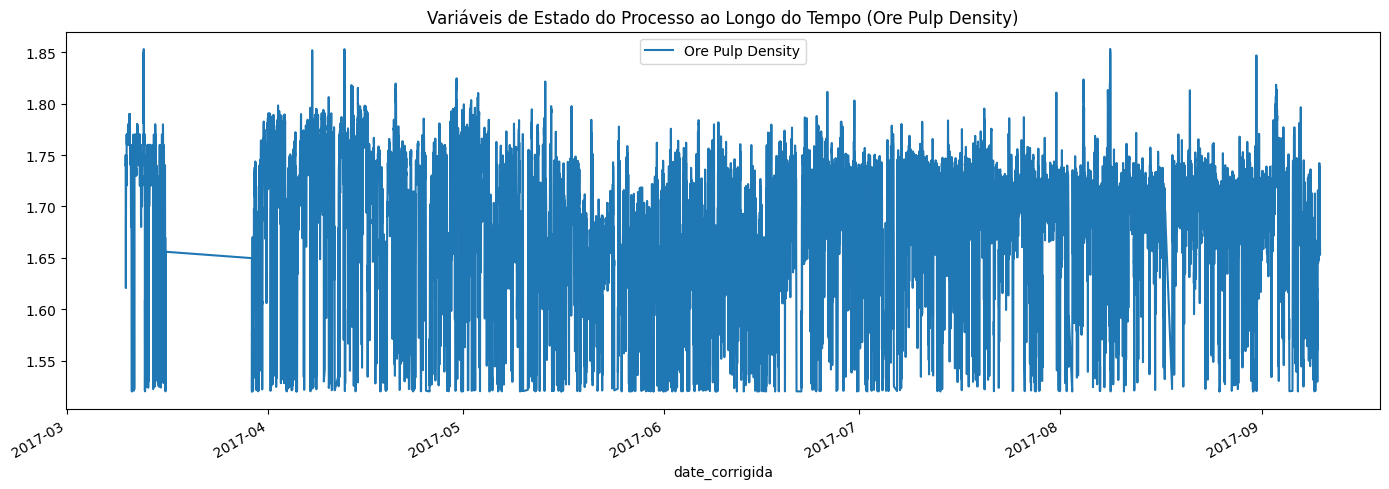

In [17]:
state_vars = ["Ore Pulp Density"]

df.plot(
    x="date_corrigida",
    y=state_vars,
    figsize=(14, 5),
    title="Variáveis de Estado do Processo ao Longo do Tempo (Ore Pulp Density)"
)
plt.tight_layout()
plt.show()

Ore Pulp Flow
* Série relativamente estável durante grande parte do período
* Oscilações dentro de faixa estreita
* Trecho final com comportamento distinto (queda e maior dispersão)
<br><br>
* Interpretação
    * A vazão de polpa reflete a capacidade hidráulica do sistema e:
    * apresenta estabilidade típica de sistemas com controle automático;
    * muda apenas quando há ajustes estruturais (paradas, gargalos, mudanças operacionais).

Variável de estado com forte inércia e papel indireto sobre a qualidade.\
\
Ore Pulp pH
* Variações contínuas
* Oscilações de curta escala
* Tendência suave ao longo do tempo
* Redução clara no trecho final
<br><br>
* Interpretação
* O pH é uma variável:
    * sensível;
    * continuamente ajustada;
    * fortemente ligada à eficiência da flotação.
* A queda no final do período sugere:
    * mudança deliberada de regime químico;
    * alteração no tipo de minério;
    * ou resposta a problemas operacionais.

O pH atua como variável intermediária crítica, conectando reagentes, alimentação e qualidade.\
\
Ore Pulp Density
* Alta variabilidade pontual
* Oscilações rápidas
* Faixa operacional relativamente bem definida
* Tendência suave ao longo do tempo
<br><br>
* Interpretação
* A densidade da polpa:
    * reflete balanços sólidos-líquidos;
    * responde tanto à alimentação quanto à vazão;
    * é difícil de estabilizar completamente.

Variável de estado ruidosa, mas informativa, especialmente quando analisada em janelas temporais.

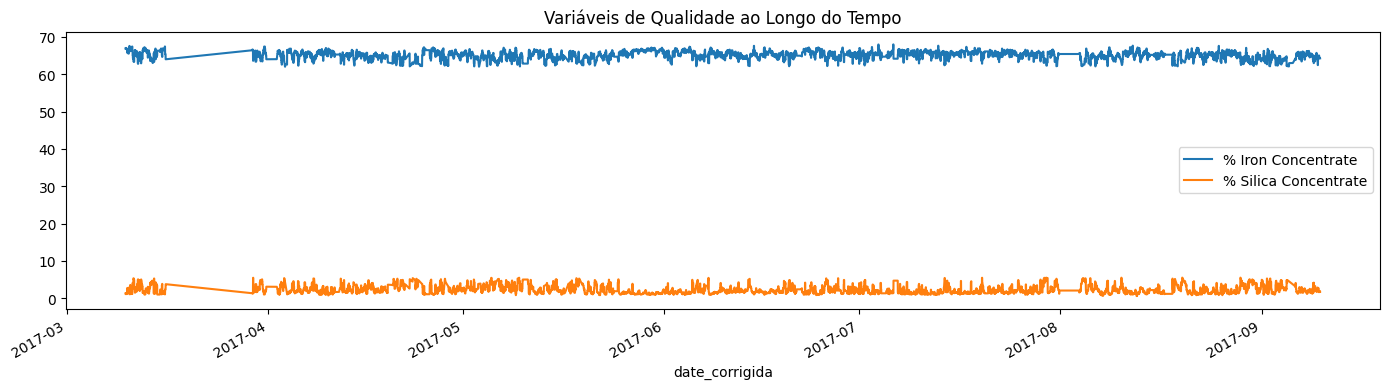

In [18]:
quality_vars = ["% Iron Concentrate", "% Silica Concentrate"]

df.plot(
    x="date_corrigida",
    y=quality_vars,
    figsize=(14, 4),
    title="Variáveis de Qualidade ao Longo do Tempo"
)
plt.tight_layout()
plt.show()

**Ainda não é a análise temporal do target em profundidade, apenas leitura estrutural.**

* Séries estáveis
* Baixa variabilidade relativa
* Oscilações pequenas e contínuas
* Relação inversa persistente entre ferro e sílica
<br><br>
* Interpretação
* A qualidade do concentrado:
    * responde de forma amortecida às variações do processo;
    * não oscila na mesma escala temporal que os reagentes;
    * reflete um sistema com capacidade de controle efetiva.

A qualidade é um efeito integrado no tempo, não uma resposta instantânea. Isso é crucial para definir lags e janelas mais à frente.

A análise exploratória temporal das variáveis de processo indica que:

- a alimentação define o contexto metalúrgico do sistema e varia em escalas longas;
- os reagentes constituem os principais instrumentos de controle em tempo quase real;
- as variáveis de estado apresentam inércia e conectam alimentação e controle;
- a qualidade do concentrado responde de forma amortecida às variações do processo;
- o sistema opera majoritariamente em regimes estáveis, com transições organizadas;
- a dinâmica temporal é essencial para compreender as relações entre variáveis.

Essas observações reforçam a necessidade de abordagens que considerem histórico,\
defasagens temporais e agregações em janelas, evitando interpretações pontuais\
ou independentes no tempo.

## Da variável dependente

## Análise Temporal das Variáveis de Qualidade

Nesta etapa, aprofunda-se a análise temporal das variáveis de qualidade
(% Iron Concentrate e % Silica Concentrate), com o objetivo de compreender:

- estabilidade e variabilidade ao longo do tempo;
- sensibilidade a mudanças operacionais;
- possíveis atrasos entre processo e resposta;
- natureza dinâmica da variável alvo.

Esta análise antecede a engenharia de atributos e a modelagem,
fornecendo subsídios para decisões metodológicas posteriores.

### Variação local em janelas temporais

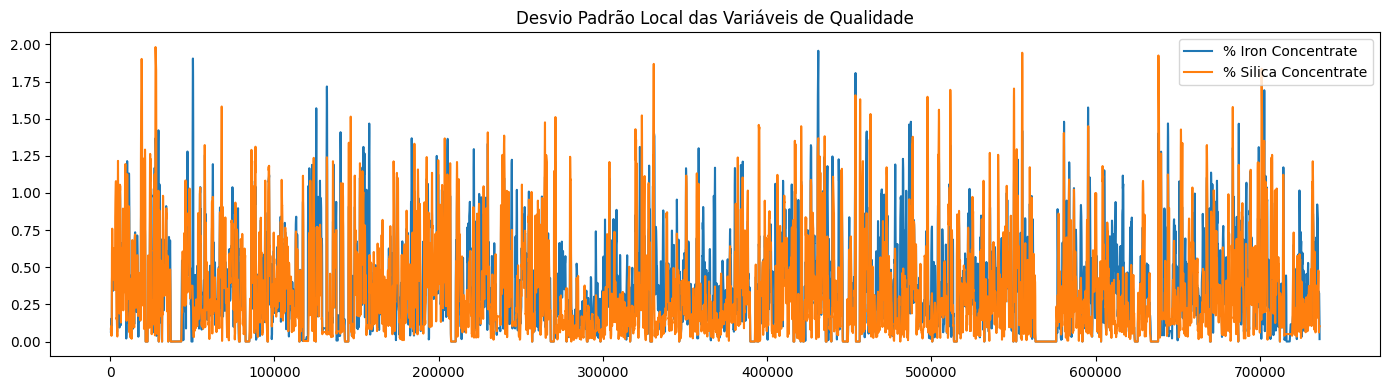

In [19]:
# para entender a dinâmica do target no tempo
# O quanto o target varia localmente, em torno de seu valor médio, dentro de uma janela temporal curta?

# Não faz sentido usar janelas menores que a frequência real de medição do target. Como a qualidade é 
# aferida em laboratório a cada hora e persistida na base, variações intrahorárias do target não representam
# informação nova. A análise temporal deve respeitar essa escala mínima.

window = 60 * 3 * 3 # 180 minutos (3 horas = 20s * 180 * 3)

rolling_std = (
    df[targets]
    .rolling(window=window)
    .std()
)

rolling_std.plot(
    figsize=(14, 4),
    title="Desvio Padrão Local das Variáveis de Qualidade"
)
plt.tight_layout()
plt.show()

**Variabilidade Local das Variáveis de Qualidade (Janela de 3 Horas)**

A figura apresenta o desvio padrão local das variáveis de qualidade\
(% Iron Concentrate e % Silica Concentrate), calculado em janelas móveis\
de aproximadamente três horas (540 observações, considerando amostragem\
a cada 20 segundos).\
\
Essa escala temporal é compatível com a natureza do target, uma vez que\
as medições de qualidade são obtidas em laboratório com periodicidade\
horária e reinseridas manualmente na base de dados.\
\
**Comportamento Observado**
Observa-se que, na maior parte do período analisado, o desvio padrão local\
permanece em níveis baixos, indicando que a qualidade do concentrado é\
mantida estável ao longo de múltiplas horas consecutivas.\
\
Esse comportamento é consistente com um processo industrial operando\
sob controle, no qual variações de curto prazo são amortecidas antes de\
se refletirem nos resultados laboratoriais.\
\
**Episódios de Aumento de Variabilidade**
O gráfico mostra picos localizados de desvio padrão para ambas as\
variáveis de qualidade, indicando períodos nos quais a variabilidade\
horária do concentrado aumenta de forma temporária.\
\
Esses episódios podem estar associados a:
- transições entre regimes operacionais;
- mudanças nas características da alimentação;
- ajustes mais agressivos nos reagentes;
- intervenções operacionais ou eventos não rotineiros.

A simultaneidade dos picos em ferro e sílica reforça a interpretação de\
que esses eventos refletem mudanças reais no comportamento do processo,\
e não ruído de medição.\
\
**Persistência do Trade-off Ferro–Sílica**
Ao longo de todo o horizonte temporal, observa-se que aumentos na\
variabilidade do teor de ferro tendem a coincidir com aumentos na\
variabilidade do teor de sílica.\
\
Esse padrão indica que o compromisso entre recuperação de\
ferro e rejeição de sílica permanece ativo mesmo quando o processo\
atravessa períodos de maior instabilidade.\
\
**Implicações Metodológicas**
A análise em janelas de três horas indica que:
- a qualidade do concentrado deve ser tratada como uma variável de\
  resposta integrada no tempo;
- variações relevantes ocorrem em escalas temporais horárias ou superiores;
- abordagens baseadas em médias, desvios e agregações temporais são mais\
  apropriadas do que análises pontuais;
- a engenharia de atributos deve respeitar a escala de medição do target.

Essas observações fundamentam a escolha de estratégias de agregação temporal\
e validação adequadas nas etapas subsequentes do projeto.

### Relação temporal entre ferro e sílica

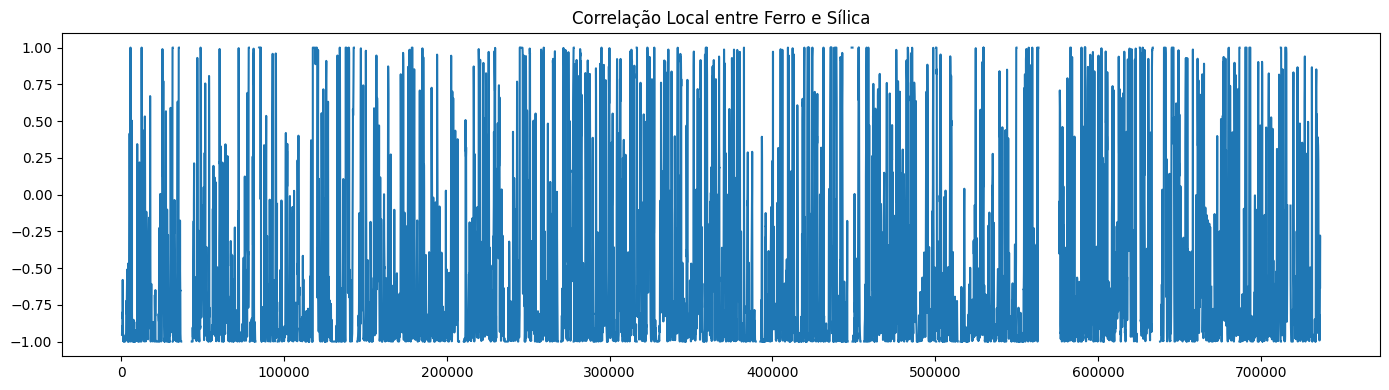

In [20]:
df[targets].rolling(window=window).corr().unstack().iloc[:,1].plot(
    figsize=(14, 4),
    title="Correlação Local entre Ferro e Sílica"
)
plt.tight_layout()
plt.show()

A figura apresenta a correlação local entre % Iron Concentrate e % Silica Concentrate,\
calculada em janelas móveis ao longo do tempo.\
\
Busca avaliar como o compromisso metalúrgico entre ferro e sílica se comporta dinamicamente,\
e não apenas em termos globais.\
\
Apesar das limitações inerentes à baixa frequência do target,
o gráfico indica que:
- o trade-off ferro–sílica está presente ao longo de todo o período;
- não há evidência de ruptura estrutural dessa relação;
- o compromisso metalúrgico é consistente entre diferentes regimes operacionais.

### Análise exploratória de autocorrelação do target

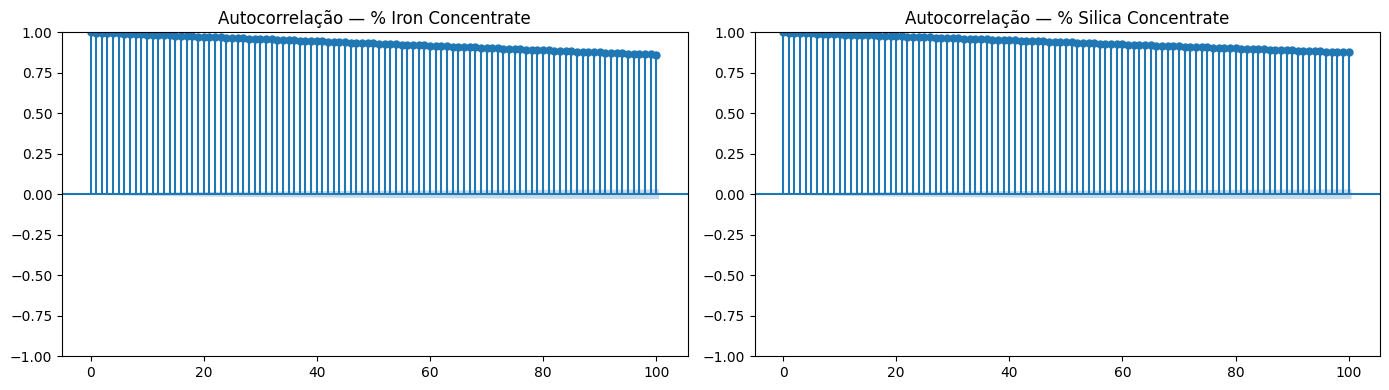

In [22]:
fig, ax = plt.subplots(1, 2, figsize=(14, 4))

plot_acf(df["% Iron Concentrate"], lags=100, ax=ax[0])
ax[0].set_title("Autocorrelação — % Iron Concentrate")

plot_acf(df["% Silica Concentrate"], lags=100, ax=ax[1])
ax[1].set_title("Autocorrelação — % Silica Concentrate")

plt.tight_layout()
plt.show()

A ACF mede o grau de dependência linear entre o valor atual da série e seus valores\
passados, sendo uma ferramenta fundamental para avaliar memória temporal e estrutura\
de dependência.\
\
Revela dependência temporal e memória longa, influenciadas pelo mecanismo de medição\
laboratorial e persistência dos valores na base.\
Esse comportamento confirma que a qualidade do concentrado é uma resposta integrada\
no tempo, exigindo abordagens de modelagem que respeitem sua natureza temporal e\
operacional.\
\
Esse padrão de autocorrelação não deve ser interpretado como resultado exclusivo da\
dinâmica física do processo, mas principalmente como consequência da forma de aquisição\
do target.\
\
As variáveis de qualidade são:
- aferidas em laboratório com periodicidade horária;
- reinseridas manualmente na base de dados;
- persistidas como valores constantes ao longo de múltiplas amostras intermediárias.

Como resultado, a série apresenta longos trechos constantes, o que gera autocorrelação\
elevada mesmo para grandes defasagens.

In [23]:
"""
Criação de um dataframe contendo apenas as medições horárias do target.

Premissas:
- As variáveis de qualidade são aferidas em laboratório a cada hora;
- Os valores intrahorários representam persistência artificial;
- Manter uma observação por hora preserva apenas medições informativas.
"""

target_cols = ["% Iron Concentrate", "% Silica Concentrate"]

df_hourly = (
    df
    .set_index("date_corrigida")
    .groupby(pd.Grouper(freq="1H"))[target_cols]
    .first()
    .dropna()
)

df_hourly.head(), df_hourly.shape

C:\Users\gabri\AppData\Local\Temp\ipykernel_30552\610343135.py:15: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  .groupby(pd.Grouper(freq="1H"))[target_cols]


(                     % Iron Concentrate  % Silica Concentrate
 date_corrigida                                               
 2017-03-10 01:00:00               66.91                  1.31
 2017-03-10 02:00:00               67.06                  1.11
 2017-03-10 03:00:00               66.97                  1.27
 2017-03-10 04:00:00               66.75                  1.36
 2017-03-10 05:00:00               66.63                  1.34,
 (4097, 2))

In [24]:
df['% Silica Concentrate'].nunique(), df['% Iron Concentrate'].nunique()

(55569, 38696)

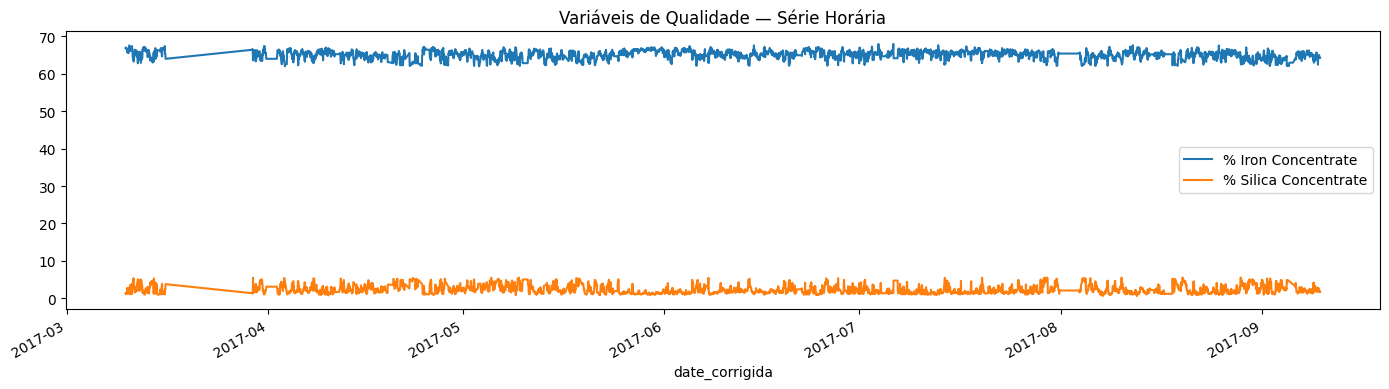

In [25]:
df_hourly.plot(
    figsize=(14, 4),
    title="Variáveis de Qualidade — Série Horária"
)
plt.tight_layout()
plt.show()

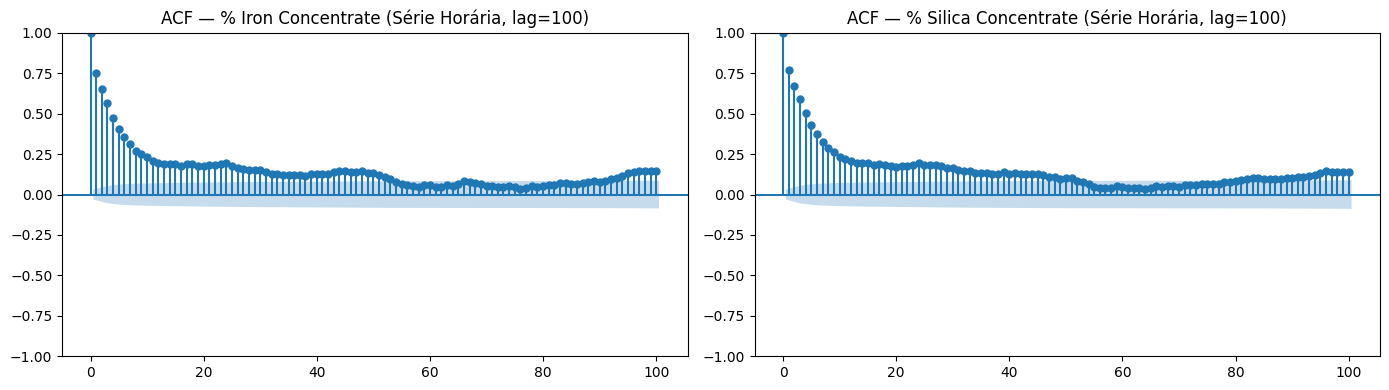

In [26]:
fig, ax = plt.subplots(1, 2, figsize=(14, 4))

plot_acf(
    df_hourly["% Iron Concentrate"],
    lags=100,
    ax=ax[0]
)
ax[0].set_title("ACF — % Iron Concentrate (Série Horária, lag=100)")

plot_acf(
    df_hourly["% Silica Concentrate"],
    lags=100,
    ax=ax[1]
)
ax[1].set_title("ACF — % Silica Concentrate (Série Horária, lag=100)")

plt.tight_layout()
plt.show()

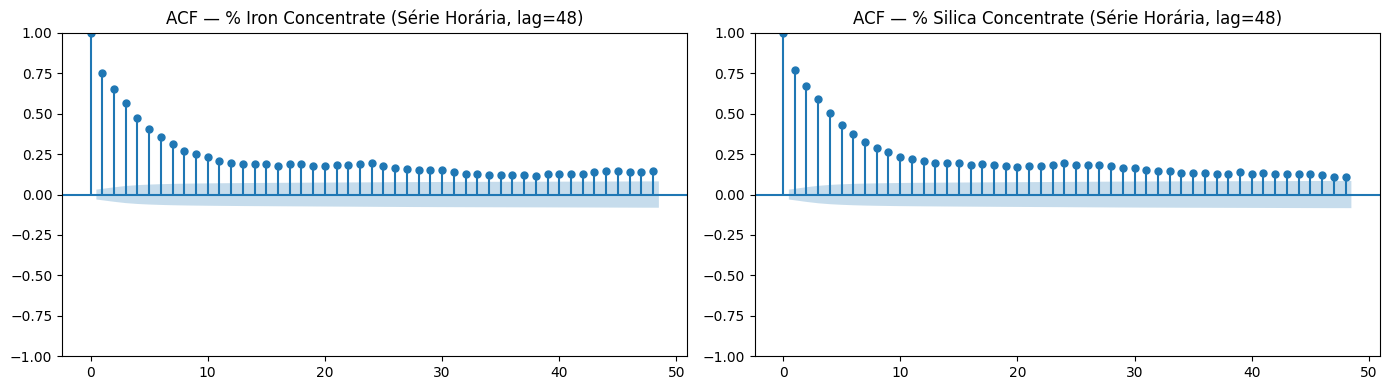

In [27]:
fig, ax = plt.subplots(1, 2, figsize=(14, 4))

plot_acf(
    df_hourly["% Iron Concentrate"],
    lags=48,
    ax=ax[0]
)
ax[0].set_title("ACF — % Iron Concentrate (Série Horária, lag=48)")

plot_acf(
    df_hourly["% Silica Concentrate"],
    lags=48,
    ax=ax[1]
)
ax[1].set_title("ACF — % Silica Concentrate (Série Horária, lag=48)")

plt.tight_layout()
plt.show()

Na análise inicial, realizada sobre a série contendo amostras a cada 20 segundos, observou-se:
- autocorrelação extremamente elevada para praticamente todas as defasagens analisadas;
- decaimento muito lento e quase linear da autocorrelação;
- ausência de uma escala temporal claramente identificável;
- dominância do efeito de persistência artificial dos valores do target.

Esse padrão reflete principalmente a replicação intrahorária de valores laboratoriais e não a\
dinâmica real do processo de flotação.
\
Após a consolidação da série para a frequência horária, observa-se um comportamento substancialmente\
distinto:
- autocorrelação elevada nos primeiros lags (1 a poucas horas);
- decaimento progressivo e mais acentuado da autocorrelação;
- redução gradual da dependência temporal à medida que o lag aumenta;
- estabilização da autocorrelação em níveis baixos para defasagens mais longas.

Esse padrão indica que a série horária captura de forma mais fiel a memória temporal efetiva do processo.\
\
Tanto para % Iron Concentrate quanto para % Silica Concentrate, observa-se:
- comportamento qualitativamente semelhante entre as duas variáveis;
- forte dependência temporal de curto prazo;
- persistência moderada em horizontes médios;
- ausência de autocorrelação significativa em defasagens longas.

A similaridade entre os padrões reforça o acoplamento estrutural entre as variáveis de qualidade\
e a natureza integrada da resposta do processo.\
\
O decaimento observado na ACF horária sugere que:
- a qualidade do concentrado responde de forma amortecida às condições do processo;
- o estado atual da qualidade carrega informação relevante sobre o futuro próximo;
- essa informação se dissipa gradualmente ao longo de algumas horas.

Isso é compatível com tempos de residência, mistura e cinética do processo de flotação.\
\
Em termos conceituais, as diferenças podem ser resumidas da seguinte forma:
- a ACF intrahorária é dominada por artefatos de persistência;
- a ACF horária revela a dependência temporal real do target;
- a série horária permite identificar escalas temporais relevantes;
- a interpretação da dinâmica do processo torna-se mais robusta e alinhada à realidade operacional.

A consolidação temporal elimina viéses artificiais e aumenta a interpretabilidade dos resultados.\
\
Com base nessa análise, conclui-se que:
- o target deve ser tratado em escala horária;
- a engenharia de atributos deve alinhar variáveis de processo a essa mesma escala;
- defasagens e janelas temporais devem ser definidas em múltiplos de horas;
- validações devem respeitar blocos temporais contínuos.

A comparação entre as funções de autocorrelação evidencia que a remoção das amostras intrahorárias\
é essencial para revelar a estrutura temporal real das variáveis de qualidade. A série horária\
apresenta dependência temporal informativa e decaimento consistente, fornecendo subsídios para a\
engenharia de atributos e a modelagem preditiva.

### Decomposição do target

**A decomposição não tem finalidade preditiva nesta fase, mas sim exploratória e diagnóstica.**\
\
A análise exploratória anterior indicou que as variáveis de qualidade:
- apresentam forte dependência temporal;
- variam de forma gradual;
- refletem respostas integradas do processo de flotação;
- são medidas em escala horária.

Nesse contexto, a decomposição permite investigar se a série pode ser interpretada como a combinação de:
- um comportamento de longo prazo;
- variações sistemáticas;
- flutuações residuais.
\
Opta-se por uma decomposição **aditiva**, assumindo que:
- a amplitude das variações não cresce proporcionalmente ao nível da série;
- os efeitos do processo se somam de forma aproximadamente linear;
- não há evidência de comportamento multiplicativo nos dados observados.
Essa escolha é coerente com processos industriais controlados, nos quais o target oscila em torno de um patamar operacional.\
\
Não se assume, a priori, a existência de sazonalidade periódica clássica (diária ou semanal), uma vez que:
- o processo opera de forma contínua;
- a variabilidade é dominada por decisões operacionais e características do minério;
- não há indícios claros de ciclos regulares no período analisado.
Assim, a decomposição é utilizada de forma exploratória, sem impor interpretações causais aos componentes sazonais.

In [28]:
"""
Decomposição temporal das variáveis de qualidade em escala horária.

Premissas:
- Série horária consolidada representa medições reais de laboratório;
- O objetivo é análise exploratória, não previsão.
"""


# Série horária do target (já construída anteriormente)
iron_ts = df_hourly["% Iron Concentrate"]
silica_ts = df_hourly["% Silica Concentrate"]

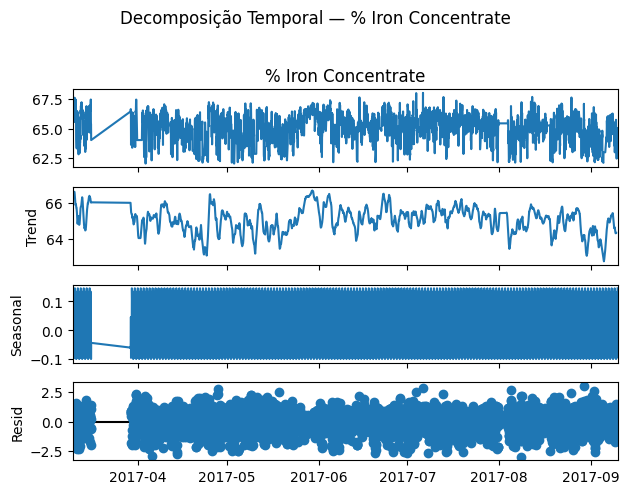

In [29]:
# O period=24 não impõe sazonalidade diária, apenas define uma escala mínima para separação de componentes. Isso deve ser explicitado no texto.
decomp_iron = seasonal_decompose(
    iron_ts,
    model="additive",
    period=24  # ciclo diário apenas como referência temporal
)

decomp_iron.plot()
plt.suptitle("Decomposição Temporal — % Iron Concentrate", y=1.02)
plt.tight_layout()
plt.show()

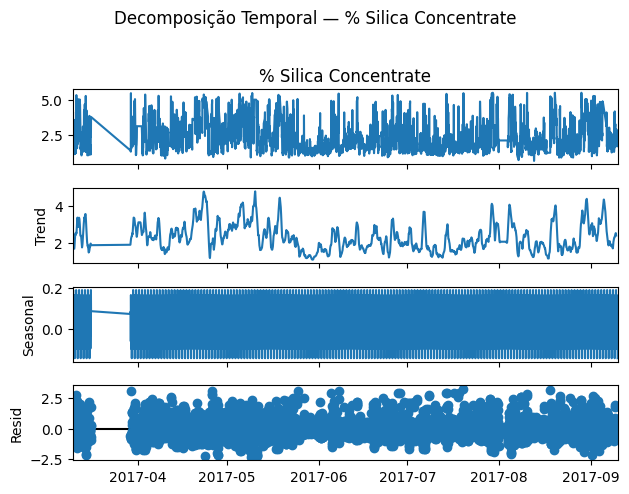

In [30]:
decomp_silica = seasonal_decompose(
    silica_ts,
    model="additive",
    period=24 #*5
)

decomp_silica.plot()
plt.suptitle("Decomposição Temporal — % Silica Concentrate", y=1.02)
plt.tight_layout()
plt.show()

A série observada de ambas as variáveis apresenta:
- variação relativamente limitada em torno de um patamar operacional;
- flutuações contínuas, porém de pequena amplitude relativa;
- ausência de saltos abruptos ou comportamentos caóticos.

Esse padrão é compatível com um processo industrial operando sob controle, no qual a qualidade do concentrado é mantida dentro de faixas estreitas.\
\
**Componente de Tendência**
A componente de tendência revela comportamentos distintos, porém coerentes, para as duas variáveis de qualidade.\
Para % Iron Concentrate:
- a tendência varia lentamente ao longo do período;
- observa-se alternância entre patamares ligeiramente mais altos e mais baixos;
- não há tendência monotônica de crescimento ou queda sustentada.

Para % Silica Concentrate:
- a tendência apresenta oscilações de maior amplitude relativa;
- essas oscilações são inversamente relacionadas às do teor de ferro;
- a tendência sugere ajustes graduais no desempenho do processo.

Em ambos os casos, a tendência reflete mudanças de médio e longo prazo associadas a decisões operacionais, características do minério e ajustes\
estratégicos do processo, e não deriva estatística de curto prazo.\
\
**Componente Sazonal**
\
A componente sazonal apresenta comportamento de baixa amplitude e alta frequência, sem padrão periódico claramente interpretável em termos\
operacionais.\
\
Esse padrão indica que:
- não há evidência de sazonalidade física clássica (diária ou semanal);
- a decomposição está capturando pequenas flutuações sistemáticas introduzidas pelo método estatístico;
- o componente sazonal não deve ser interpretado como ciclo real do processo.

Portanto, a sazonalidade observada deve ser considerada um artefato da decomposição, e não um fenômeno operacional significativo.\
\
**Componente Residual**
\
O componente residual concentra a maior parte da variabilidade de curto prazo observada nas séries.\
\
Observa-se que:
- os resíduos estão centrados em torno de zero;
- a variância residual é relativamente estável ao longo do tempo;
- não há evidência de heterocedasticidade pronunciada;
- existem flutuações pontuais, mas sem estrutura temporal clara.

Isso sugere que, após a remoção da tendência, a variabilidade remanescente corresponde principalmente a ruído operacional e pequenas\
perturbações não-sistemáticas do processo.

A decomposição temporal, à luz dos dados reais, indica que a maior parte da informação relevante do target está contida na componente\
de tendência. Não há justificativas para modelar sazonalidade explícita, pois o contexto do problema não apresenta o comportamento\
cíclico como um padrão do processo de flotação.
A variabilidade residual é limitada e pouco estruturada, e abordagens baseadas em agregações temporais e histórico recente são mais\
adequadas do que modelos que buscam padrões periódicos.

## Conclusões da Análise Exploratória

A análise exploratória dos dados, conduzida de forma progressiva e alinhada à realidade operacional do processo de flotação, permite\
consolidar as seguintes conclusões:

- O dataset descreve um sistema industrial dinâmico, no qual as observações não são independentes no tempo e a ordem temporal é\
  elemento central para a interpretação dos dados.

- As variáveis de alimentação apresentam variações em escalas longas e funcionam como condições de contorno do processo, refletindo\
  características do minério e decisões operacionais de maior nível.

- As vazões de reagentes constituem os principais instrumentos de controle ativo, exibindo alta variabilidade e resposta rápida a\
  mudanças no contexto operacional.

- As variáveis de estado do processo apresentam comportamento mais suave, com inércia física e química, conectando as condições de\
  alimentação às ações de controle.

- As variáveis de qualidade são aferidas em laboratório com periodicidade horária e apresentam comportamento altamente estável,\
  com variações graduais e amortecidas ao longo do tempo.

- A consolidação da série do target para a escala horária elimina persistência artificial e revela uma estrutura temporal mais\
  interpretável, com autocorrelação elevada em defasagens curtas e decaimento progressivo em horizontes maiores.

- O compromisso metalúrgico entre teor de ferro e teor de sílica é uma característica estrutural do processo, persistente ao longo\
  do tempo e manifestada principalmente em escalas de médio e longo prazo.

- A decomposição temporal das variáveis de qualidade indica que a maior parte da informação relevante está associada à componente de\
  tendência, sem evidência de sazonalidade operacional significativa.

- Não há indícios de comportamento caótico ou instabilidade crônica; o processo opera predominantemente em regimes estáveis, com\
  transições organizadas associadas a mudanças operacionais relevantes.

Em conjunto, essas evidências indicam que o problema deve ser abordado em escala horária, com engenharia de atributos baseada em\
agregações temporais, defasagens coerentes com a dinâmica do processo e validação temporal apropriada. Essas decisões fundamentam\
a transição para a etapa de engenharia e seleção de atributos.